Human text

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "cnn2011/CNN_Articels_clean_2/CNN_Articels_clean.csv"
with open(path) as f:
    df = pd.read_csv(f)

print(df.shape)
print(df.columns)

(37949, 11)
Index(['Index', 'Author', 'Date published', 'Category', 'Section', 'Url',
       'Headline', 'Description', 'Keywords', 'Second headline',
       'Article text'],
      dtype='object')


In [2]:
def is_single_person(author):
    return not (
        len(author.split()) < 2
        or re.search(r"\b(Staff|Reuters)\b", author, re.IGNORECASE)
        or " and " in author
        or author == "By "
    )

In [3]:
df = df.dropna(subset=["Article text", "Author"])
df = df[df["Article text"].str.len() > 100]
df = df[df["Author"].map(is_single_person)]

author = df["Author"].value_counts().head(1).index
# author = df["Author"].value_counts().iloc[20:21].index
df = df[df["Author"].isin(author)]

In [4]:
from sklearn.model_selection import train_test_split

train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

for author, group in df.groupby("Author"):
    train, test = train_test_split(group, test_size=0.5)
    train_df = pd.concat([train_df, train])
    test_df = pd.concat([test_df, test])

In [5]:
# 1 word ~ 5 characters
charcount = 10000


def split_text(text, charcount):
    text = text[: len(text) - (len(text) % charcount)]
    return [text[i : i + charcount] for i in range(0, len(text), charcount)]

In [6]:
train = " ".join(train_df["Article text"])
train_subsets = split_text(train, charcount)
train_subsets_df = pd.DataFrame(train_subsets, columns=["Text chunk"])

AI text

In [7]:
ai_df = pd.read_csv("rewrites.csv")
ai_train_df, ai_test_df = train_test_split(ai_df, test_size=0.5)
ai_train = " ".join(ai_train_df["Generated text"])
ai_subsets = split_text(ai_train, charcount)
ai_subsets_df = pd.DataFrame(ai_subsets, columns=["Text chunk"])

In [8]:
ai_df.shape

(2314, 1)

Feature extraction

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

with open("vocab.txt", "r") as file:
    vocab = file.read().splitlines()

print(vocab)

vectorizer = CountVectorizer(
    vocabulary=vocab, stop_words=None, token_pattern=r"(?u)\b\w+\b"
)

train_subsets_df["Count"] = list(
    vectorizer.transform(train_subsets_df["Text chunk"]).toarray()
)
train_subsets_df["Proportion"] = train_subsets_df["Count"].apply(
    lambda x: x / x.sum() if x.sum() != 0 else x
)

ai_subsets_df["Count"] = list(
    vectorizer.transform(ai_subsets_df["Text chunk"]).toarray()
)
ai_subsets_df["Proportion"] = ai_subsets_df["Count"].apply(
    lambda x: x / x.sum() if x.sum() != 0 else x
)

['the', 'be', 'are', 'been', 'is', 's', 'was', 'were', 'of', 'and', 'to', 'a', 'an', 'in', 'have', 'had', 'has', 'it', 'he', 'his', 'that', 'i', 'for', 'they', 'their', 'you', 'not', 't', 'on', 'she', 'her', 'with', 'as', 'this', 'we', 'at', 'by', 'but', 'from', 'or', 'which', 'will', 'there', 'no', 'can', 'if', 'what', 'would', 'so', 'up']


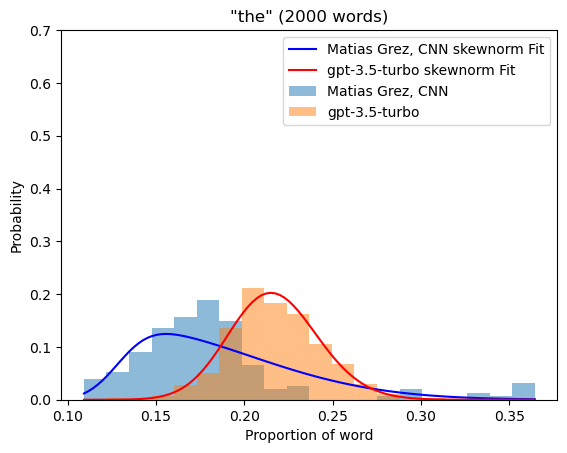

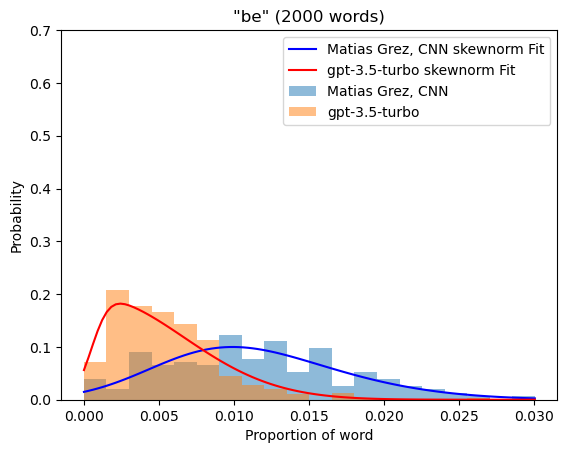

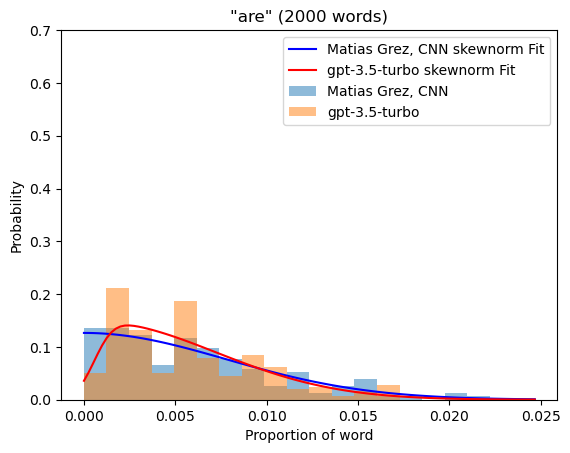

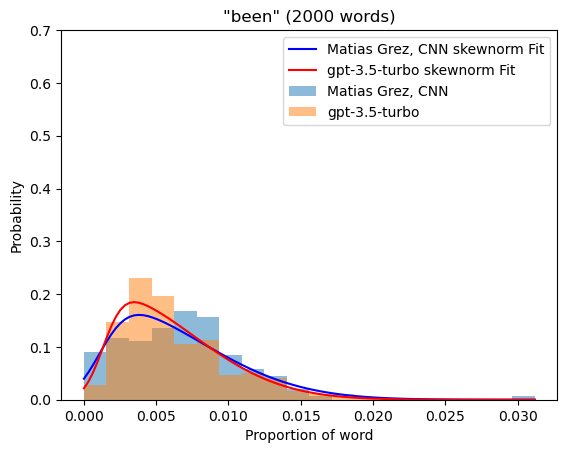

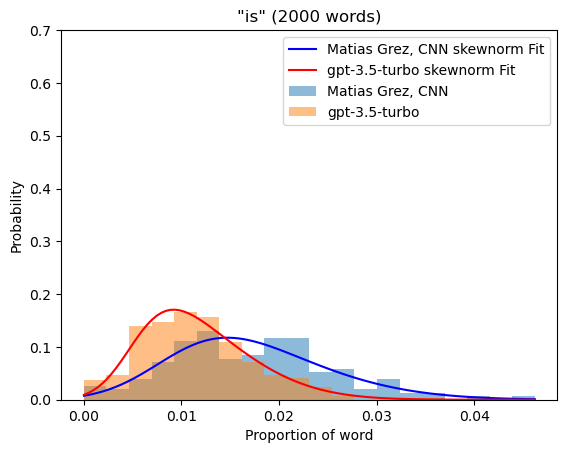

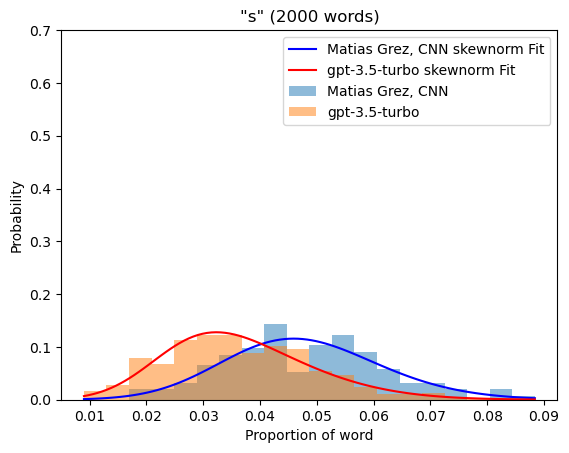

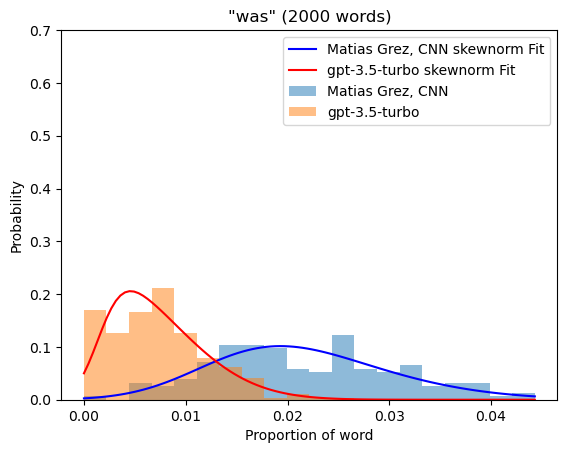

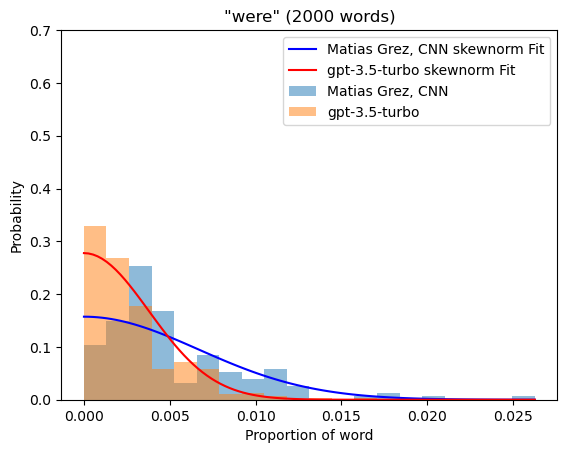

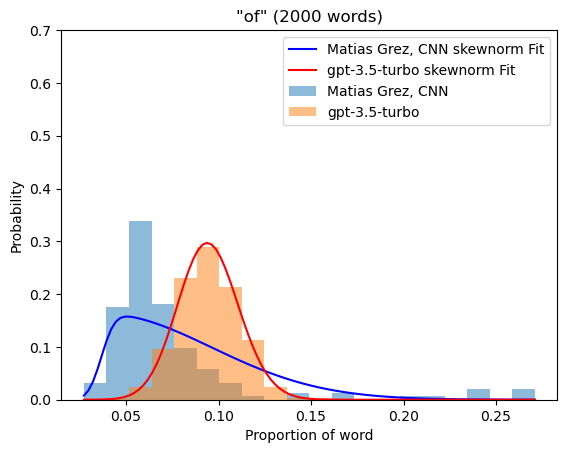

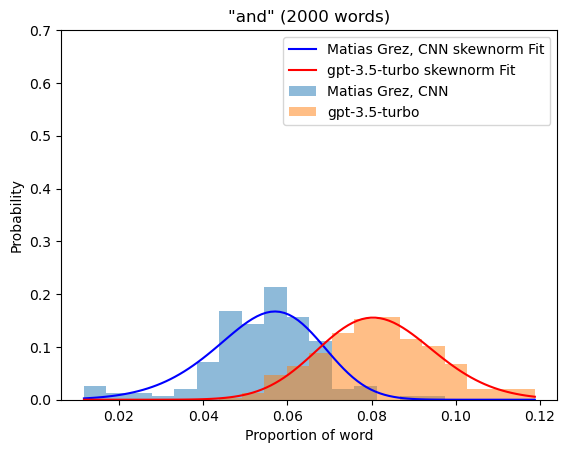

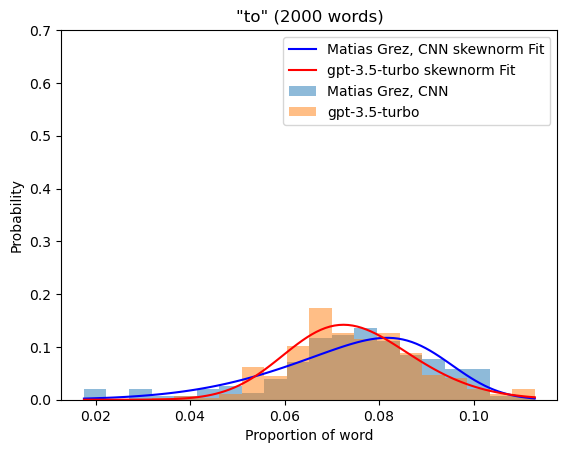

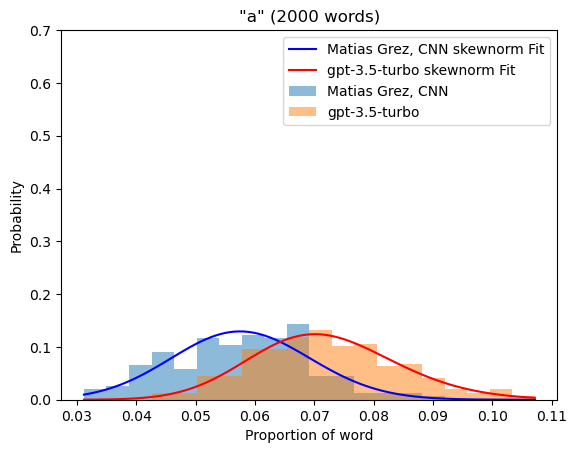

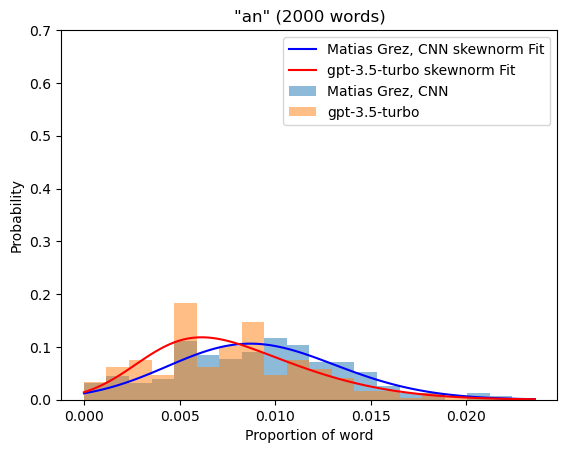

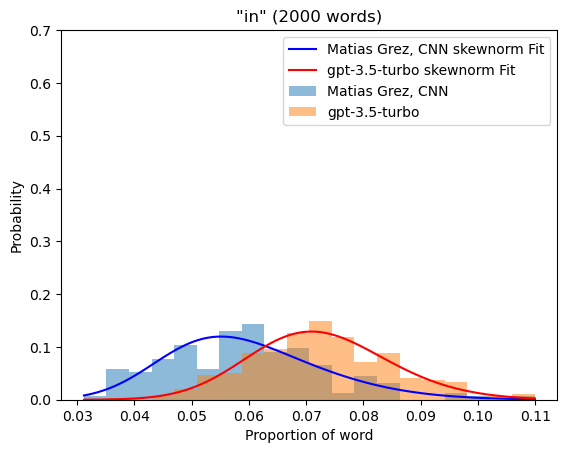

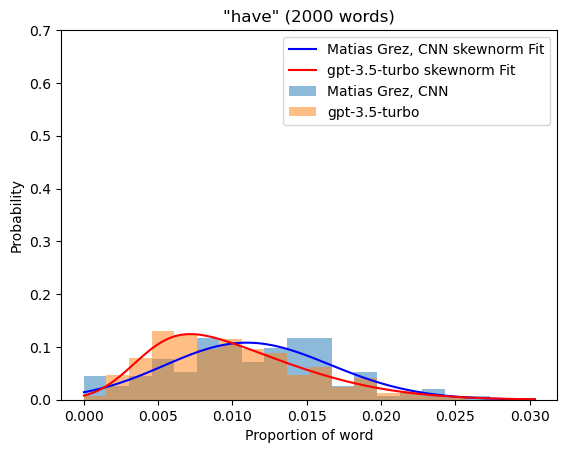

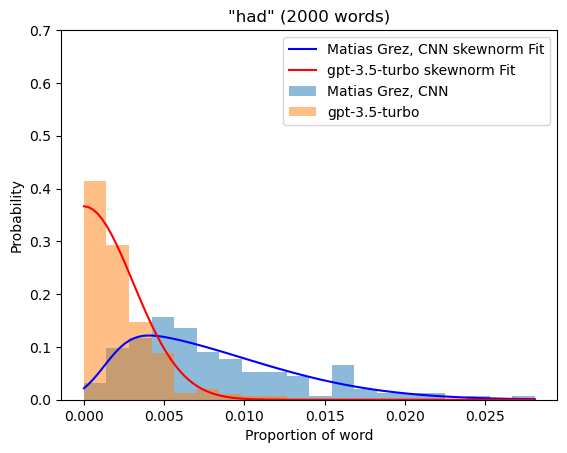

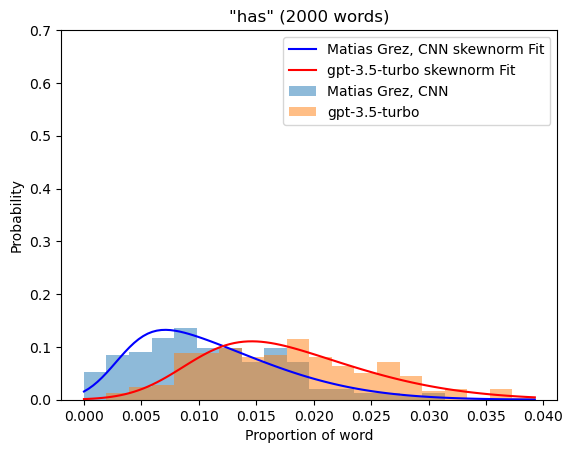

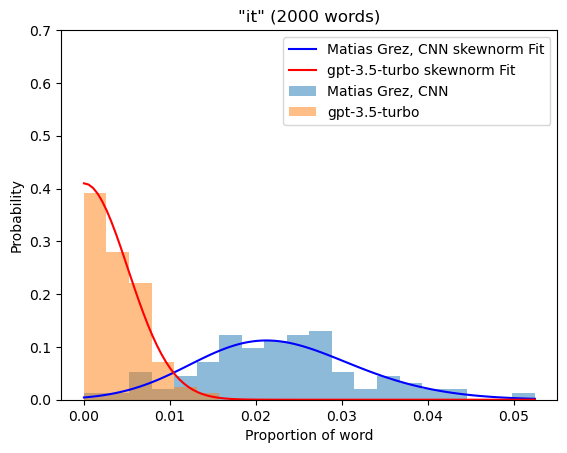

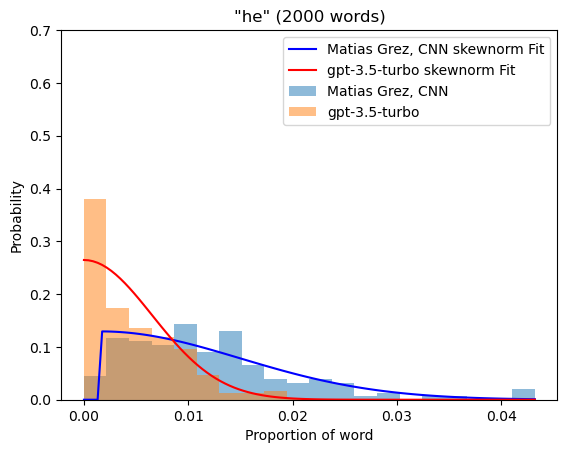

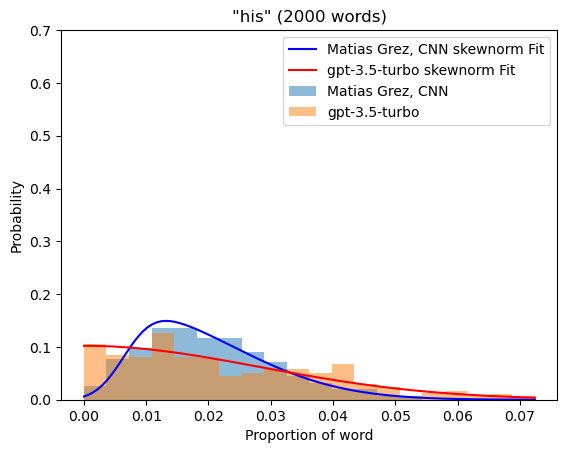

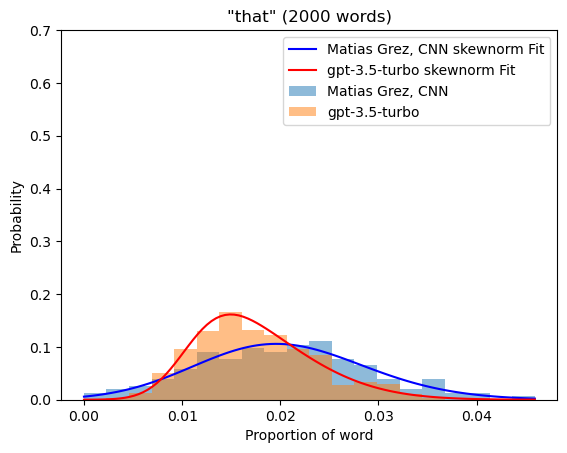

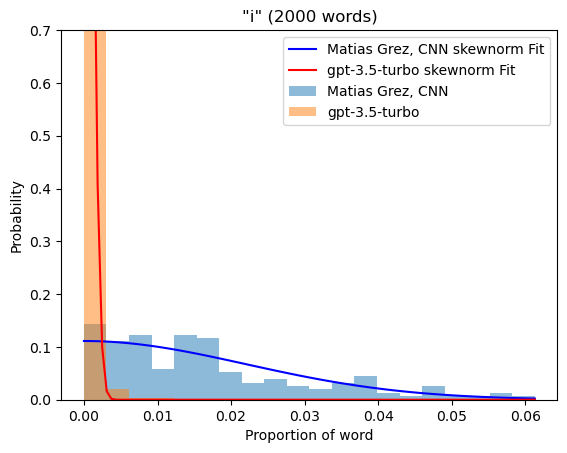

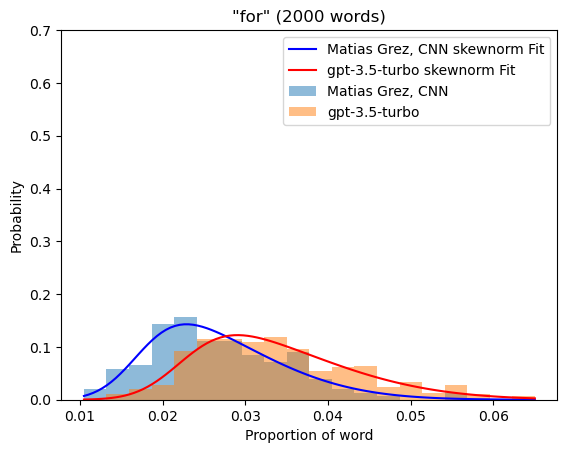

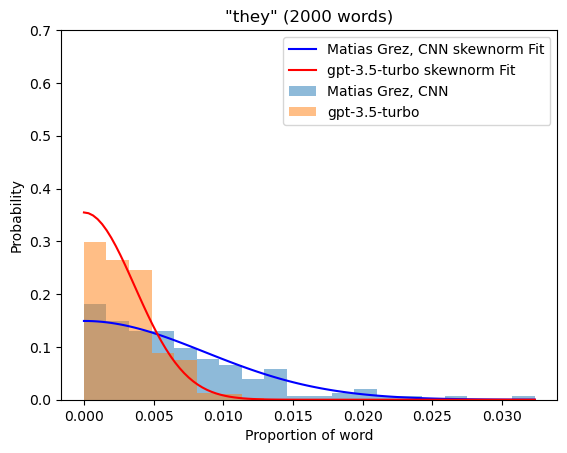

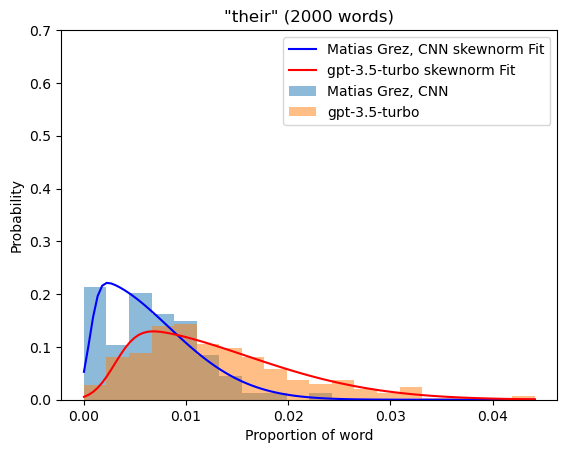

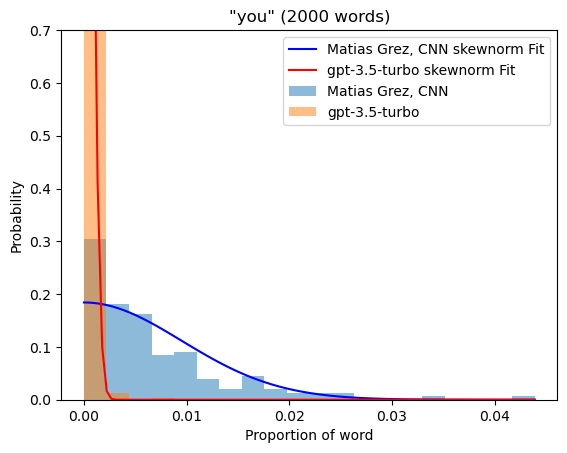

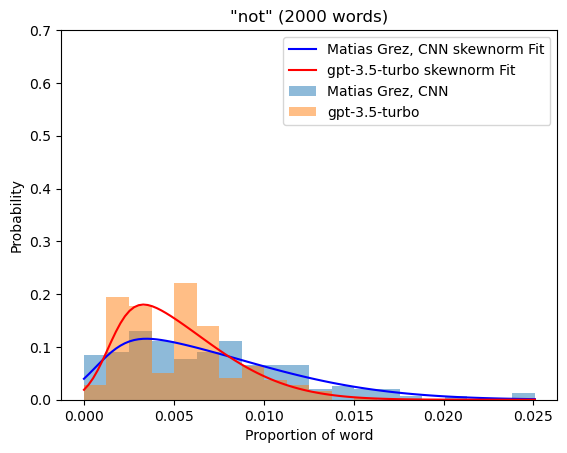

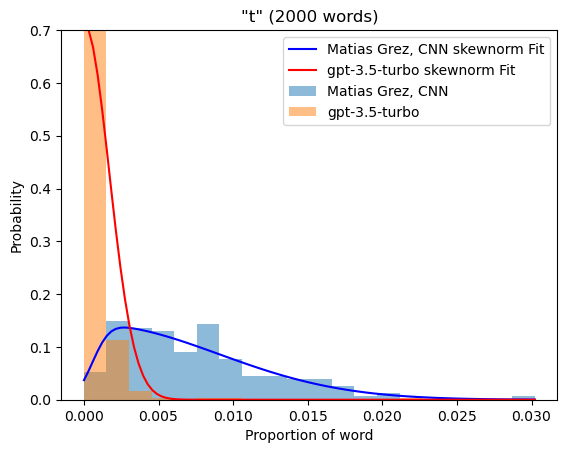

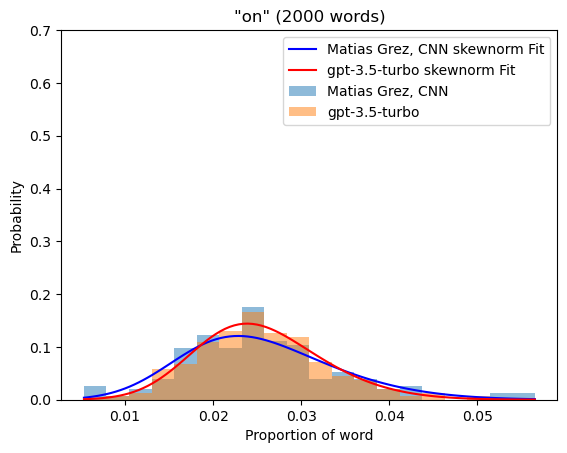

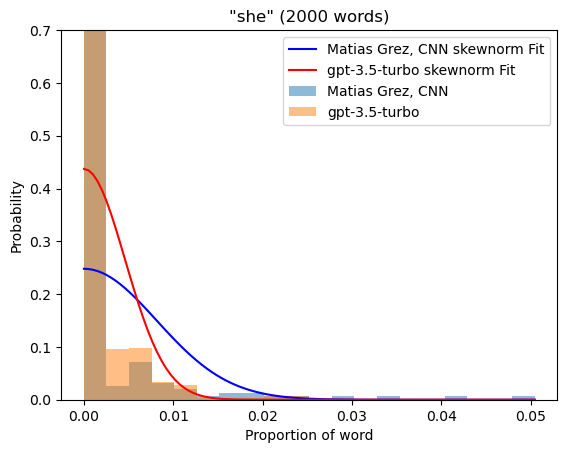

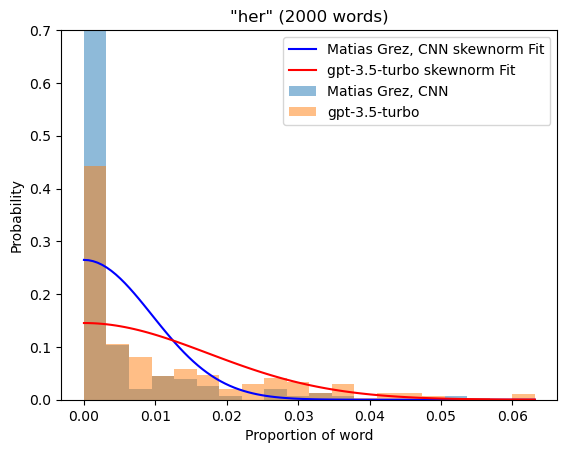

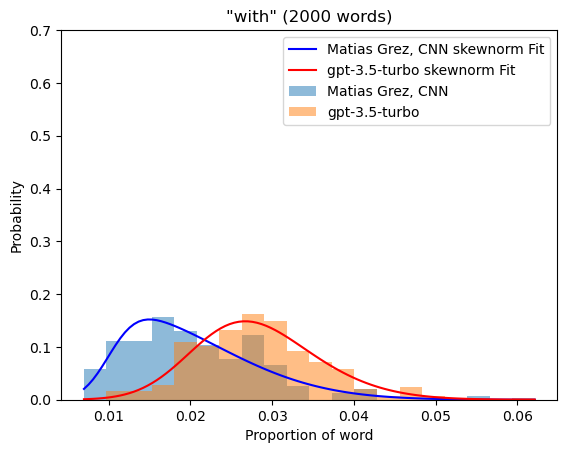

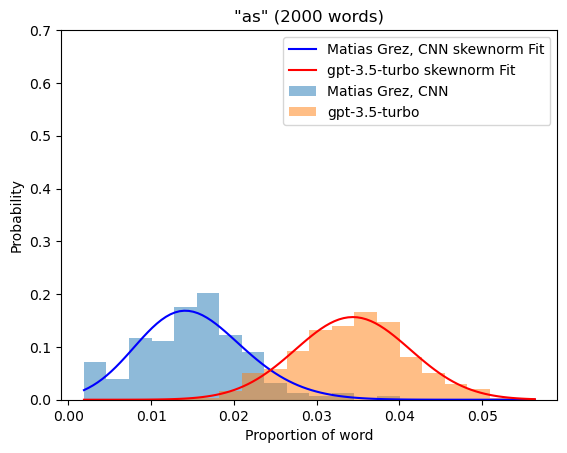

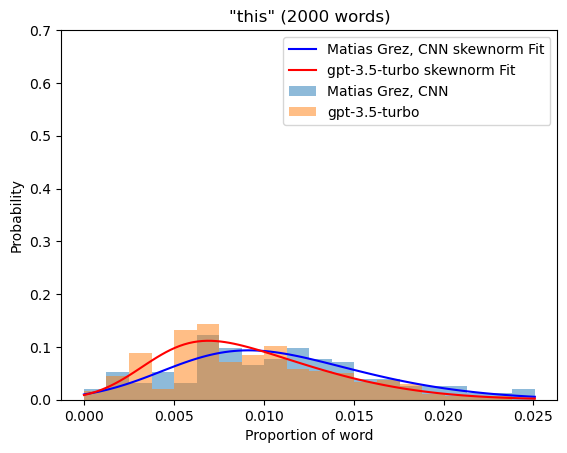

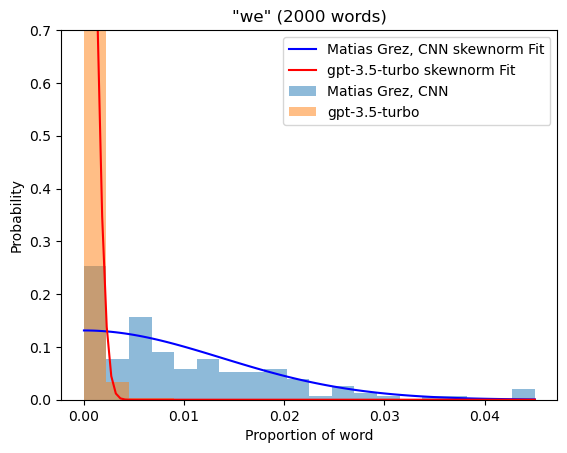

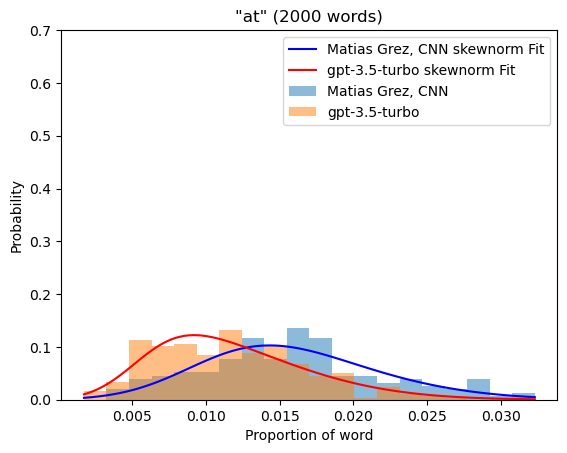

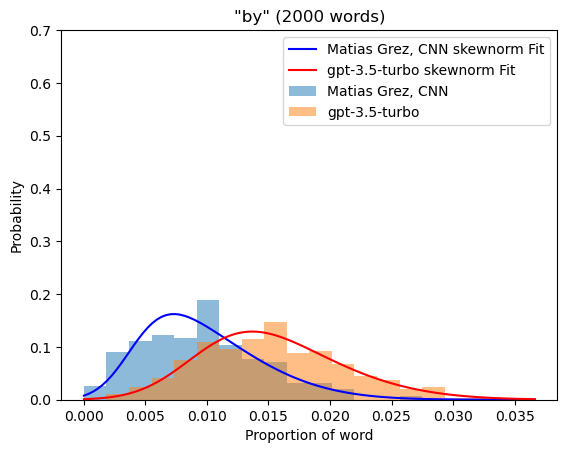

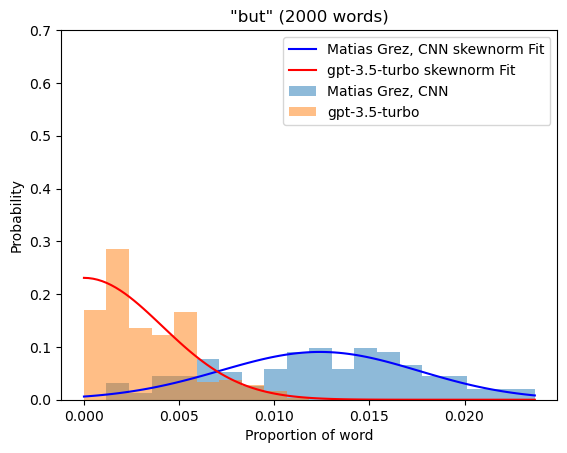

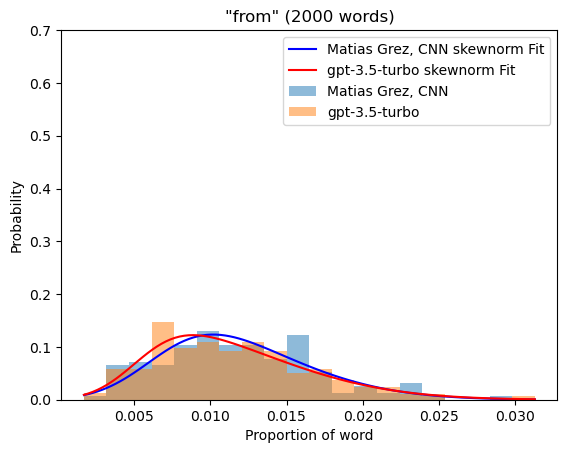

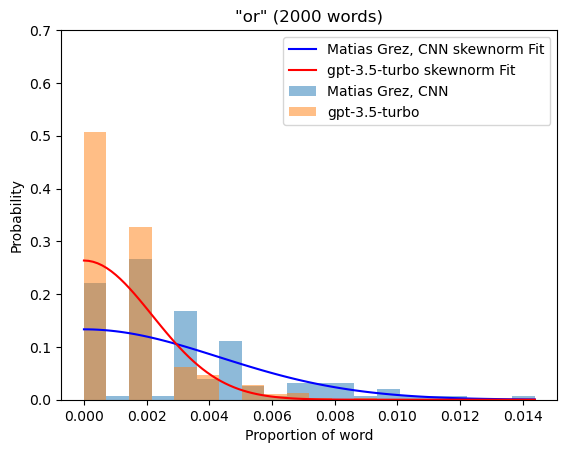

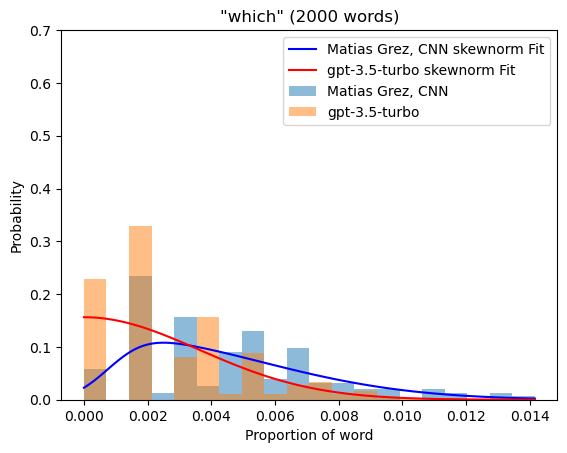

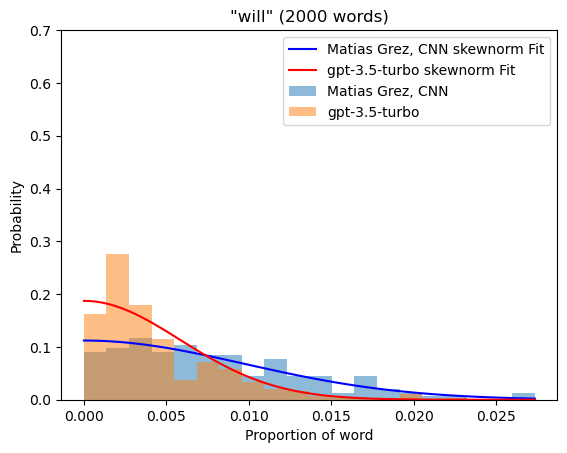

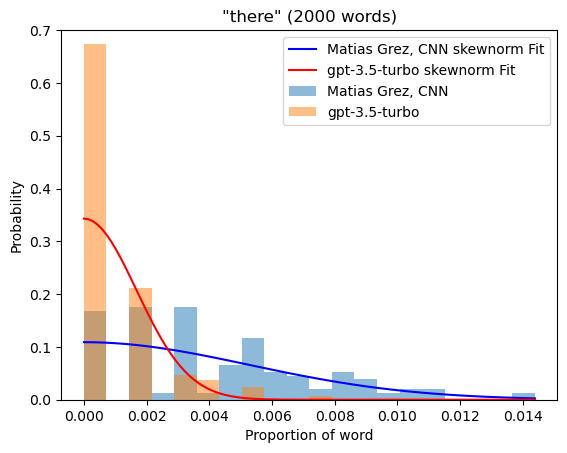

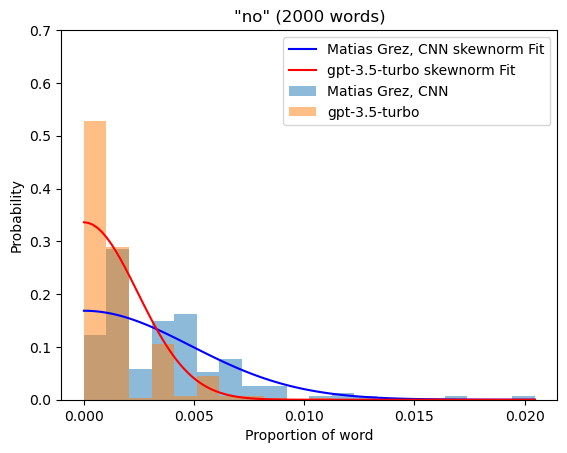

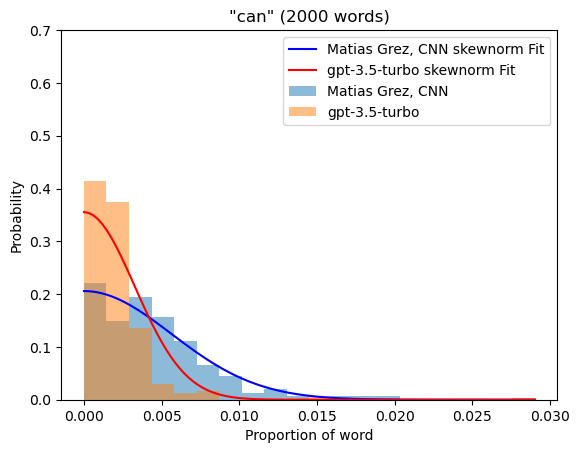

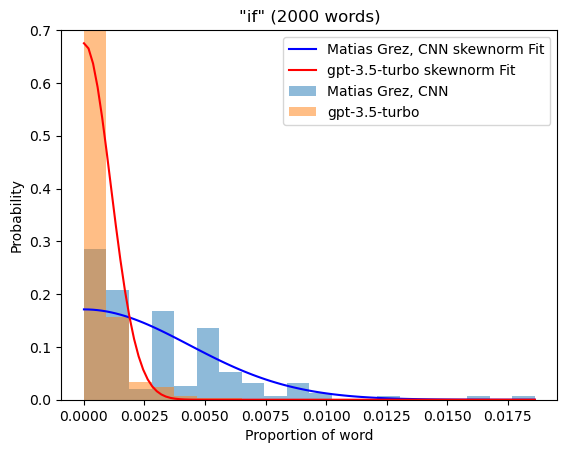

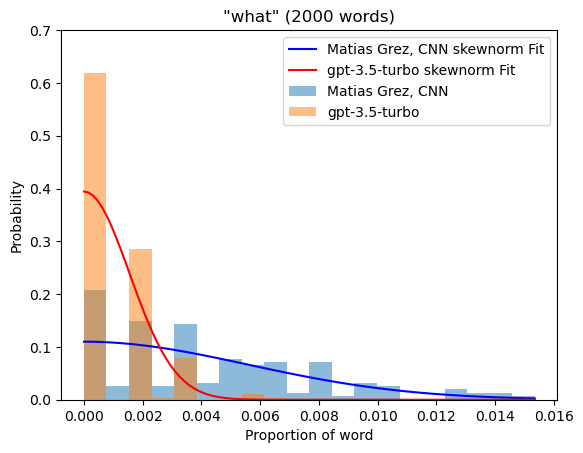

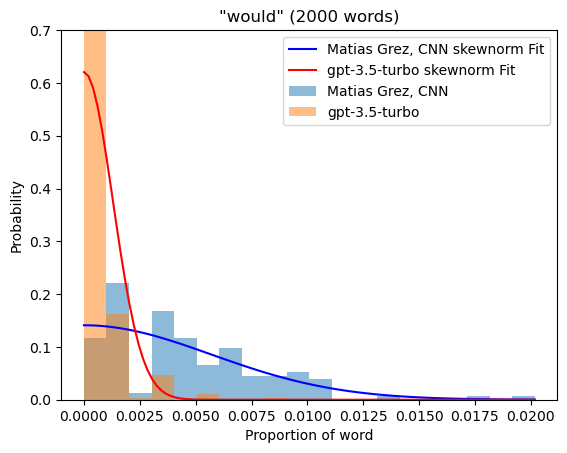

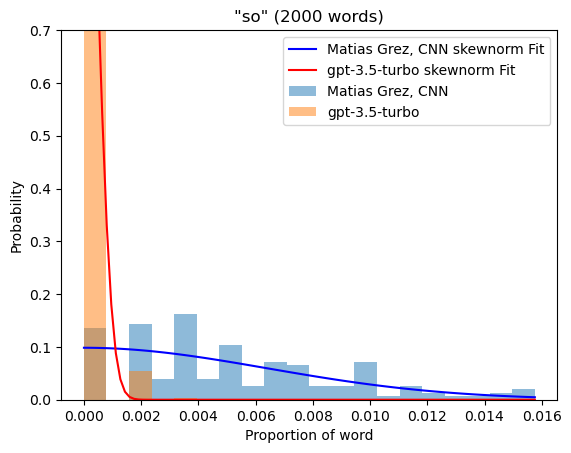

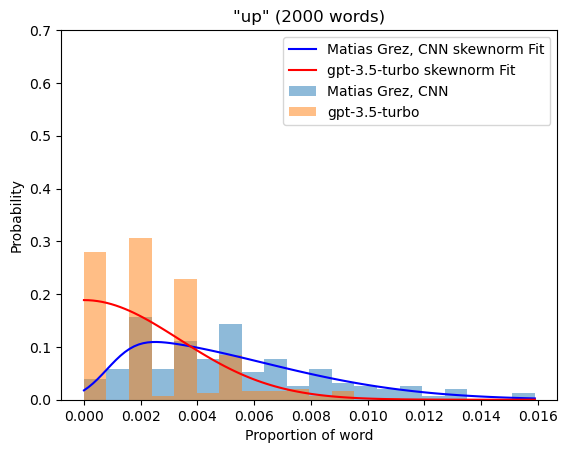

In [10]:
from scipy.stats import skewnorm

feature_names = vectorizer.get_feature_names_out()
human_name = author
ai_name = "gpt-3.5-turbo"
human_fit_params = []
ai_fit_params = []

for i, feature in enumerate(feature_names):
    humandist = train_subsets_df["Proportion"].apply(lambda x: x[i])
    aidist = ai_subsets_df["Proportion"].apply(lambda x: x[i])

    combined_data = np.concatenate((humandist, aidist))
    bins = np.histogram_bin_edges(combined_data, bins=20)

    human_hist, _ = np.histogram(humandist, bins=bins)
    ai_hist, _ = np.histogram(aidist, bins=bins)

    human_hist_scaled = human_hist / len(train_subsets)
    ai_hist_scaled = ai_hist / len(ai_subsets)

    plt.bar(
        bins[:-1],
        human_hist_scaled,
        width=np.diff(bins),
        alpha=0.5,
        label=human_name,
        align="edge",
    )
    plt.bar(
        bins[:-1],
        ai_hist_scaled,
        width=np.diff(bins),
        alpha=0.5,
        label=ai_name,
        align="edge",
    )

    human_params = skewnorm.fit(humandist)
    ai_params = skewnorm.fit(aidist)

    x = np.linspace(min(combined_data), max(combined_data), 100)
    bin_width = np.diff(bins)[0]

    human_skewnorm_pdf = skewnorm.pdf(x, *human_params) * bin_width
    ai_skewnorm_pdf = skewnorm.pdf(x, *ai_params) * bin_width

    plt.plot(x, human_skewnorm_pdf, "b-", label=human_name + " skewnorm Fit")
    plt.plot(x, ai_skewnorm_pdf, "r-", label=ai_name + " skewnorm Fit")

    human_fit_params.append(human_params)
    ai_fit_params.append(ai_params)

    plt.legend(loc="upper right")
    plt.title(f'"{feature}" ({charcount//5} words)')
    plt.ylabel("Probability")
    plt.xlabel("Proportion of word")
    plt.ylim(0, 0.7)
    plt.show()

dist_fits = pd.DataFrame(columns=["Feature", "Human Skewnorm Fit", "AI Skewnorm Fit"])
dist_fits["Feature"] = feature_names
dist_fits["Human Skewnorm Fit"] = human_fit_params
dist_fits["AI Skewnorm Fit"] = ai_fit_params

In [11]:
def get_p(x, dist_params):
    a, loc, scale = dist_params
    p_value = skewnorm.cdf(x, a=a, loc=loc, scale=scale)
    p_value = 2 - 2 * p_value if p_value > 0.5 else 2 * p_value
    return p_value

In [12]:
def p_value(vector, dist_fits):
    p_values = []
    for i, feature in enumerate(feature_names):
        human_params = dist_fits.iloc[i]
        p_values.append(get_p(vector[i], human_params))
    # p_values = sorted(p_values)[3:]
    return np.mean(p_values)

In [13]:
human_test = " ".join(test_df["Article text"])
human_test_subsets = split_text(human_test, charcount)
human_test_subsets_df = pd.DataFrame(human_test_subsets, columns=["Text chunk"])

In [14]:
human_test_subsets_df["Vectors"] = list(
    vectorizer.transform(human_test_subsets_df["Text chunk"]).toarray()
)
human_test_subsets_df["Vectors"] = human_test_subsets_df["Vectors"].apply(
    lambda x: x / x.sum() if x.sum() != 0 else x
)

human_test_subsets_df["p_human"] = human_test_subsets_df["Vectors"].apply(
    lambda x: p_value(x, dist_fits["Human Skewnorm Fit"])
)
human_test_subsets_df["p_ai"] = human_test_subsets_df["Vectors"].apply(
    lambda x: p_value(x, dist_fits["AI Skewnorm Fit"])
)

human_test_subsets_df["Prediction"] = (
    human_test_subsets_df["p_human"] > human_test_subsets_df["p_ai"]
)

human_test_subsets_df["Prediction"].mean()

0.9738562091503268

In [15]:
ai_test = " ".join(ai_test_df["Generated text"])
ai_test_subsets = split_text(ai_test, charcount)
ai_test_subsets_df = pd.DataFrame(ai_test_subsets, columns=["Text chunk"])

In [16]:
ai_test_subsets_df["Vectors"] = list(
    vectorizer.transform(ai_test_subsets_df["Text chunk"]).toarray()
)
ai_test_subsets_df["Vectors"] = ai_test_subsets_df["Vectors"].apply(
    lambda x: x / x.sum() if x.sum() != 0 else x
)

ai_test_subsets_df["p_human"] = ai_test_subsets_df["Vectors"].apply(
    lambda x: p_value(x, dist_fits["Human Skewnorm Fit"])
)
ai_test_subsets_df["p_ai"] = ai_test_subsets_df["Vectors"].apply(
    lambda x: p_value(x, dist_fits["AI Skewnorm Fit"])
)

ai_test_subsets_df["Prediction"] = (
    ai_test_subsets_df["p_human"] < ai_test_subsets_df["p_ai"]
)

ai_test_subsets_df["Prediction"].mean()

0.8771331058020477